# Create color palette using K-means in Python

Recently I came across [this post](https://twitter.com/AnnaHenschel/status/1308204007840714752) on Twitter, where people created a color palette from the picture, which is pretty cool. One thing that came across to my mind is that this can be done by using the k-means clustering method. As I started to write the code to generate the color palette, it turned out that it is a very good exercise to understand the usage of the k-means cluster algorithm and its limitation.

Recall that, the [limitations](https://developers.google.com/machine-learning/clustering/algorithm/advantages-disadvantages) of k-means are
- Choosing *k* manually
- Its solution depends on initial values
- Clustering outliers
- Scaling with number of dimensions.

While I was working on extracting the colors from pictures, I encountered the first two limitations listed above.

### Pick a simple case to test the k-means cluster method
To make my life simple, I start with a simple picture, which I know what the answer is. Here, I pick a picture with five distinct colors.
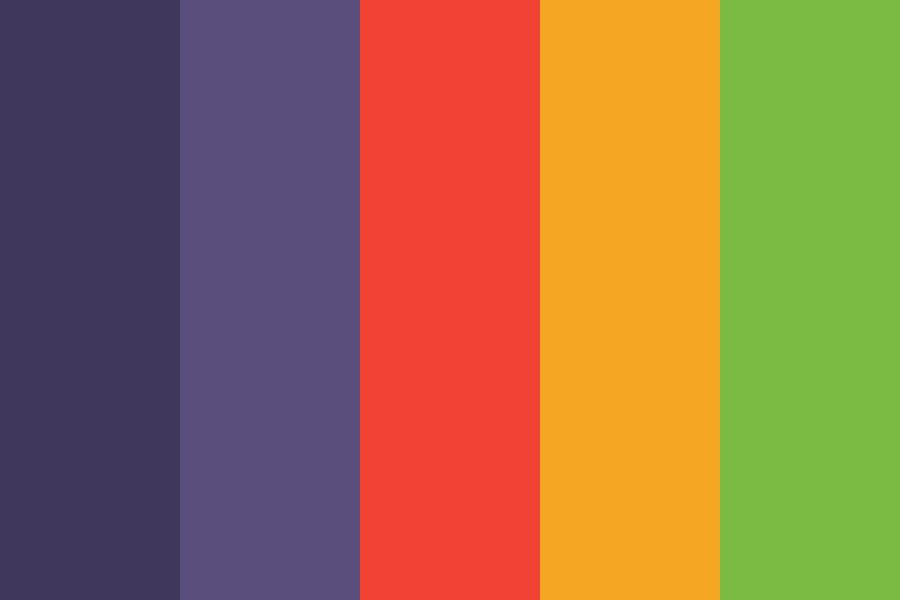
$$Figure~1$$ 
This suggests that there should be five cluster centers for the k-means clustering algorithm. But when I am starting running the function `get_colors`, I got different color centers. One of the solutions is generated by the following code
```
image = Image.open("colors.jpg")
image_np = np.array(image)
resized_color, distortion = get_colors(image_np, num_center=5, seed=1234)`
```
and the color centers are ploted as Figure 2. 
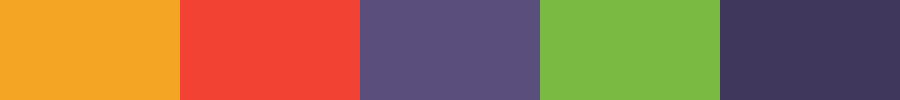 
$$Figure~2$$ 

### Encounter an issue: solutions changed due to different initialization 
It seems to me that the k-means clustering works pretty well in Figure 2 and I implemented the code correctly. However, if I set the `seed=0` then the color centers are given by Figure 3.
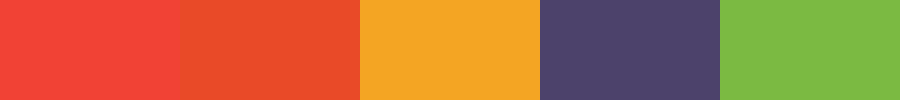
$$Figure~3$$
The color centers in Figure 3 are also generated by the same code with a different seed for initial values of the clustering algorithm. This is an example that shows the solution of the k-means algorithm depends on its initial values. By inspection, we can tell that Figure 2 is a better solution than Figure 3. We can also draw the same conclusion by looking their distortions: The distortions for color centers in Figure 2 is 0.0193 and that in Figure 3 is 0.247.

To figure out what optimal solutions could be for a given number of cluster centers, I wrote a function `find_seed` to generate a sample of a solution with different `seed`s for random initialization and a fixed number of clusters.
```
results_seeds = find_seed(image_np, num_center = 5, max_num=4)
```  
| seed | k | distortion |
| --- | --- | --- |
|0|5|0.24735649986163816|
|1|4|0.24848404559578777|
|2|5|0.01930473710059479|
|3|5|0.24719760260470366|

and their corresponding plots:
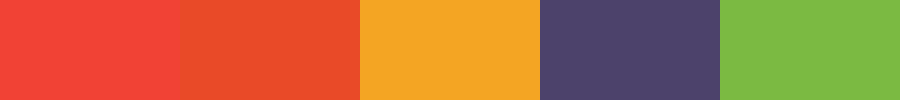 
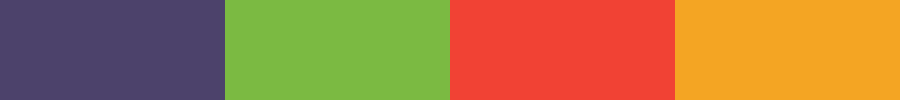 
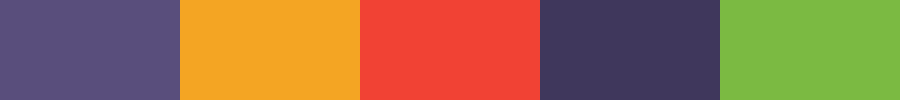 
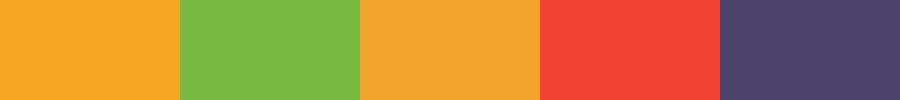 

**Observation**
There are two observations here. one observation is that vanishing cluster center. Although the number of centers is set to 5, there are only 4 cluster centers. Another observation is that all the solutions are different and there is one solution with the smallest distortion among them.  

In general, to mitigate the dependence on initial values, we can run k-means several times and pick the best result. 

### How to pick *k*
Now I presend that I don't know what the *k* is. One of the way is using the [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)). To do that, I wrote a funciton `find_k`. 
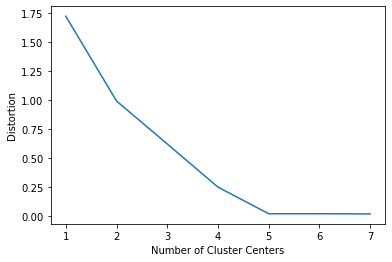
$$Figure~4$$

Figure 4 suggests that 5 is the optimal choice for *k*.

### Let's generate the color palette
Now I am a better understanding of the k-means cluster method and let's generate the color palette. 
```
image = Image.open("ponyo_photo.jpg")
image_np = np.array(image)
resized_color, distortion = get_colors(image_np, num_center=7, seed=1234)
get_concat_v(image, resized_color)
```
Here is the picture with color palettes:
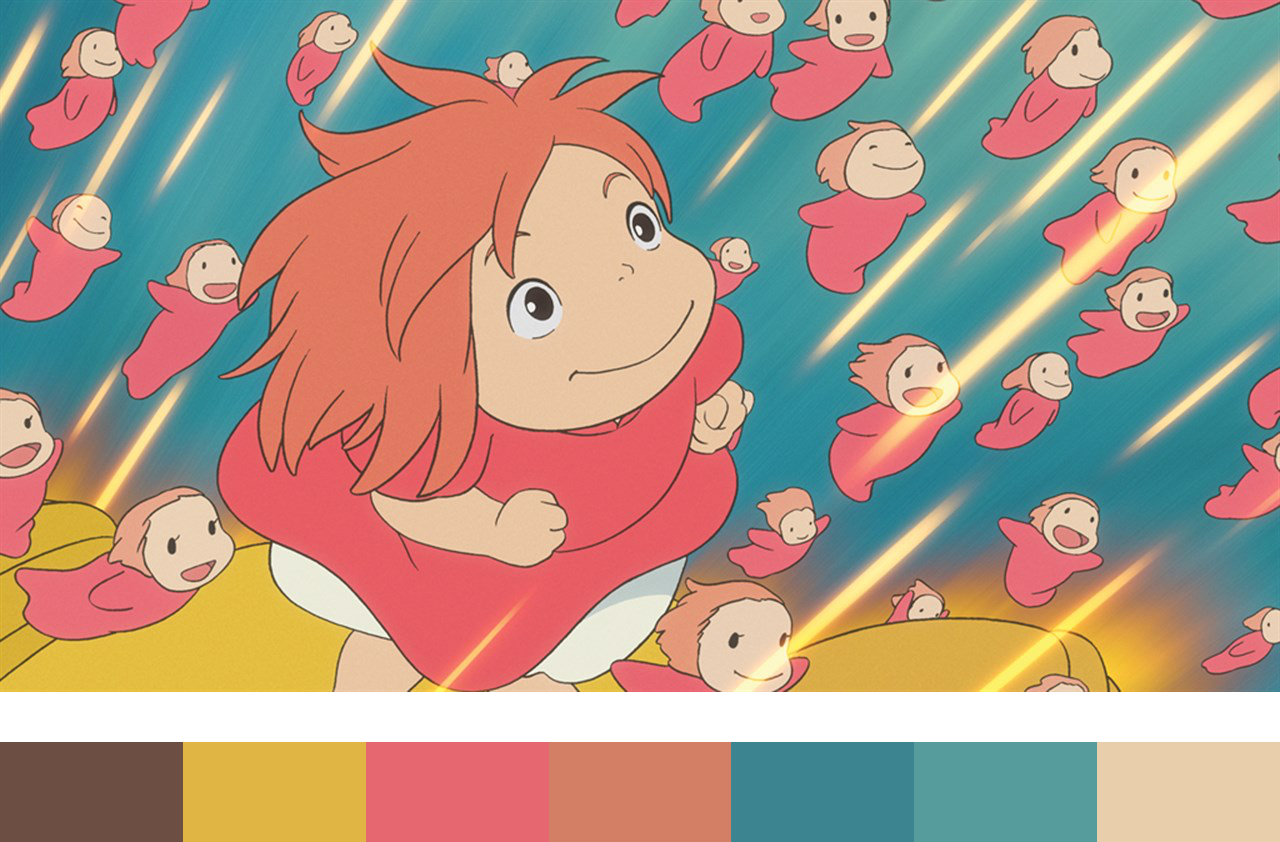 
The number of centers that I used is 7. What do you think of the optimal number for *k* is? Here is the Elow plot:
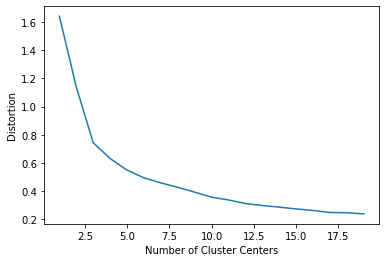

In [ ]:
import matplotlib.image as img
import matplotlib.pyplot as plt
%matplotlib inline  
from PIL import Image
import pandas as pd
import numpy as np
from scipy.cluster.vq import whiten, kmeans, vq

def get_colors(image_np, num_center=5, seed=123):
    # Preprocessing the image
    cluster_data, r_std, g_std, b_std = get_data(image_np)
    # Generate color centers using k-means
    np.random.seed(seed)
    cluster_centers, distortion = kmeans(cluster_data, num_center)
    colors = scale_center(cluster_centers, r_std, g_std, b_std)
    
    # Generate color palette from color centers
    color_palettes = np.array([colors])   
    im = Image.fromarray(np.uint8(color_palettes * 255))
    resized_color = im.resize((image_np.shape[1], 100), Image.NEAREST)
    
    return resized_color, distortion

def get_data(image_np):
    # Form a dataframe and preprocessing the data
    red, blue, green = get_color(image_np)
    df_colors = pd.DataFrame({"red": red, "blue": blue, "green": green})
    cluster_data = df_colors[["red", "blue", "green"]].apply(lambda x: whiten(x), axis=0)
    r_std, g_std, b_std = df_colors[['red', 'blue', 'green']].std()
    return cluster_data, r_std, g_std, b_std 
    
def scale_center(cluster_centers, r_std, g_std, b_std): 
    colors = []
    for cluster_center in cluster_centers:
        scaled_r, scaled_g, scaled_b = cluster_center
        # Convert each standardized value to scaled value
        colors.append((
            scaled_r * r_std / 255,
            scaled_g * g_std / 255,
            scaled_b * b_std / 255
        ))
    return colors 

def get_color(image):
    # Extract colors from image interm of red, blue, and green pixel
    red = []
    green = []
    blue = []
    for row in image:
        for temp_r, temp_g, temp_b in row:
            red.append(float(temp_r))
            green.append(float(temp_g))
            blue.append(float(temp_b))
    return [red, green, blue]
    
def get_concat_v(im1, im2, gap=50):
    # Concatenate image with color palettes
    dst = Image.new('RGB', (im1.width, im1.height + gap + im2.height), (255, 255, 255))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height +  gap))
    return dst  

def find_k(image_np, max_num = 7, seed=123):   
    # Find the number of cluster centers using Elow's method for a given seed
    cluster_data, r_std, g_std, b_std = get_data(image_np)
    np.random.seed(seed)
    distortions = []
    num_centers = []
    num_cluster_centers=[]
    color_centers = []
    for num_center in range(1, max_num):
        cluster_centers, distortion = kmeans(cluster_data, num_center)
        
        colors = scale_center(cluster_centers, r_std, g_std, b_std)
        color_palettes = np.array([colors])   
        im = Image.fromarray(np.uint8(color_palettes * 255))
        resized_color = im.resize((image_np.shape[1], 100), Image.NEAREST)
        
        distortions.append(distortion)
        num_centers.append(num_center)
        num_cluster_centers.append(len(cluster_centers))
        color_centers.append(resized_color)
        
    result = {"num_centers": num_centers,
              "num_cluster_centers": num_cluster_centers,
              "distortions": distortions,
              "color_centers":color_centers
             }
    return result

def find_seed(image_np, num_center=7, max_num=10):   
    # Find the seed for random initialization that minimizes 
    # the distortion for a given number of cluster center
    cluster_data, r_std, g_std, b_std = get_data(image_np)
    distortions = []
    seeds = []
    num_cluster_centers=[]
    color_centers = []
    for seed in range(max_num):
        np.random.seed(seed)
        cluster_centers, distortion = kmeans(cluster_data, num_center)
        
        colors = scale_center(cluster_centers, r_std, g_std, b_std)
        color_palettes = np.array([colors])   
        im = Image.fromarray(np.uint8(color_palettes * 255))
        resized_color = im.resize((image_np.shape[1], 100), Image.NEAREST)
        
        distortions.append(distortion)
        seeds.append(seed)
        num_cluster_centers.append(len(cluster_centers))
        color_centers.append(resized_color)
        
    result = {"seeds": seeds,
              "num_cluster_centers": num_cluster_centers,
              "distortions": distortions,
              "color_centers":color_centers
             }
    return result

In [ ]:
image = Image.open("ponyo_photo.jpg")
image_np = np.array(image)
resized_color, distortion = get_colors(image_np, num_center=7, seed=1234)
get_concat_v(image, resized_color)

In [ ]:
results = find_k(image_np, max_num = 20, seed=123)
plt.plot(results['num_centers'],results['distortions'])
plt.xlabel('Number of Cluster Centers')
plt.ylabel('Distortion')

In [ ]:
results_seeds = find_seed(image_np, num_center = 5, max_num=4)

In [ ]:
display(image)
for item in results_seeds['color_centers']: display(item)

In [ ]:
# Code to print table with Markdown 
for index, item in enumerate(results_seeds['seeds']): 
    print("|{}|{}|{}|".format(item, results_seeds['num_cluster_centers'][index], results_seeds['distortions'][index] ))